In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img,img_to_array,save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np

In [2]:

path="Desktop/blood group detection/dataset_blood_group"

In [3]:

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30
num_classes = 8


In [10]:
def load_images(data_dir):
    X, y = [], []
    class_map = {'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}

    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                img_path = os.path.join(label_path, image_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = np.stack((img,)*3, axis=-1)  # Convert to 3-channel
                X.append(img)
                y.append(class_map[label])

    return np.array(X), np.array(y)

In [11]:
class_map = {'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}


In [12]:
# Load dataset from single folder
X, y = load_images("dataset_blood_group") # Change "data" to the actual path of your dataset

In [13]:
X = X / 255.0

In [14]:
# Convert labels to categorical
NUM_CLASSES = 8  
y = tf.keras.utils.to_categorical(y, NUM_CLASSES)

In [15]:
# Split into training (80%) and validation (20%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 4800, Validation samples: 1200


In [16]:
# Build CNN Model
from tensorflow.keras import models, layers, regularizers, optimizers # Import necessary modules

def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)), # Change input_shape to (IMG_SIZE, IMG_SIZE, 3)
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),

        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Train model
model = build_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [17]:
# Train and validate the model
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/30
150/150 [==============================] - 117s 768ms/step - loss: 1.8516 - accuracy: 0.4458 - val_loss: 0.8755 - val_accuracy: 0.7900
Epoch 2/30
150/150 [==============================] - 118s 789ms/step - loss: 0.8979 - accuracy: 0.7358 - val_loss: 0.6014 - val_accuracy: 0.8483
Epoch 3/30
150/150 [==============================] - 120s 803ms/step - loss: 0.7681 - accuracy: 0.7738 - val_loss: 0.5386 - val_accuracy: 0.8575
Epoch 4/30
150/150 [==============================] - 117s 779ms/step - loss: 0.7118 - accuracy: 0.7987 - val_loss: 0.5735 - val_accuracy: 0.8350
Epoch 5/30
150/150 [==============================] - 113s 755ms/step - loss: 0.6515 - accuracy: 0.8185 - val_loss: 0.5115 - val_accuracy: 0.8633
Epoch 6/30
150/150 [==============================] - 116s 775ms/step - loss: 0.6301 - accuracy: 0.8221 - val_loss: 0.5094 - val_accuracy: 0.8542
Epoch 7/30
150/150 [==============================] - 115s 766ms/step - loss: 0.6077 - accuracy: 0.8265 - val_loss: 0.4835 -

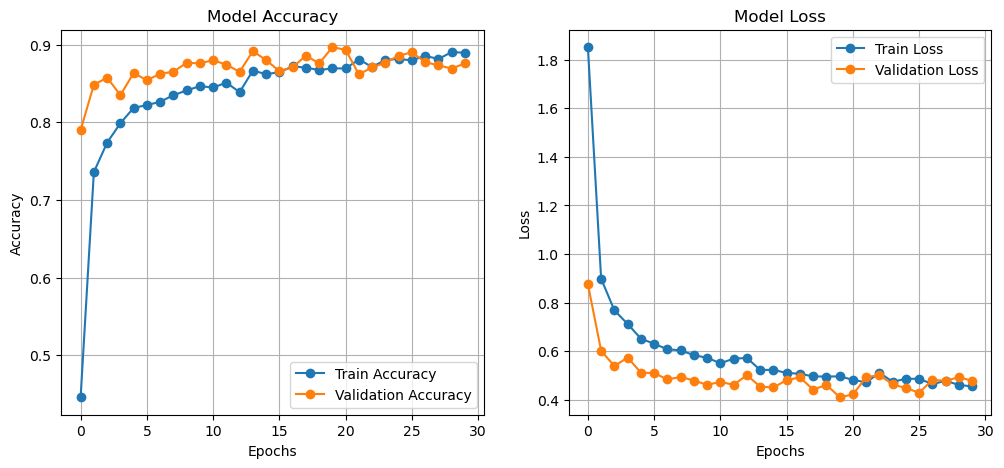

In [18]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.show()

plot_training_history(history)


38/38 [==============================] - 5s 127ms/step


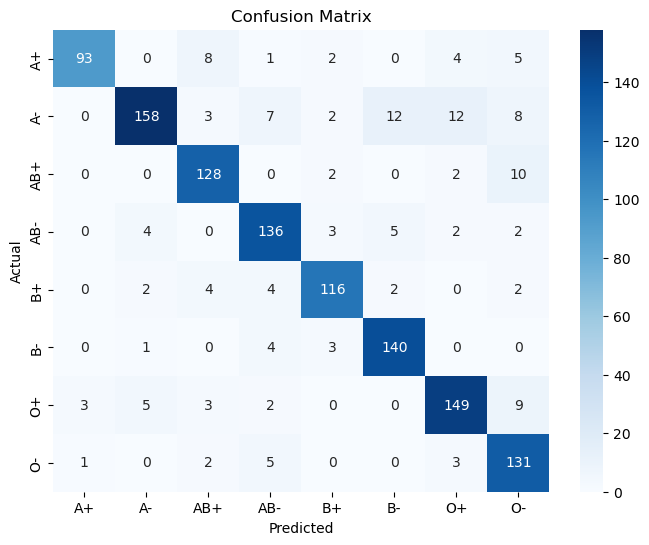

Classification Report:
              precision    recall  f1-score   support

          A+       0.96      0.82      0.89       113
          A-       0.93      0.78      0.85       202
         AB+       0.86      0.90      0.88       142
         AB-       0.86      0.89      0.87       152
          B+       0.91      0.89      0.90       130
          B-       0.88      0.95      0.91       148
          O+       0.87      0.87      0.87       171
          O-       0.78      0.92      0.85       142

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



In [19]:

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_map.keys()),
            yticklabels=list(class_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_map.keys()))

In [20]:
model.save("model.h5")
print("CNN Model trained and saved successfully!")

CNN Model trained and saved successfully!


C:\anaconda\envs\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import tensorflow as tf
import numpy as np
import cv2


In [2]:
IMG_SIZE = 128

In [3]:
model = tf.keras.models.load_model("model.h5")

In [4]:
# Class mapping
class_map = {0: 'A+', 1: 'A-', 2: 'AB+', 3: 'AB-', 4: 'B+', 5: 'B-', 6: 'O+', 7: 'O-'}

In [5]:
import cv2
import numpy as np

def preprocess_image(image_path):
    # Load image in color (BGR)
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if img is None:
        raise ValueError(f"❌ Failed to load image from {image_path}. Check the path and format.")
    
    # Resize to expected input size
    img = cv2.resize(img, (128, 128))

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize pixel values
    img = img / 255.0

    # Expand dims to match model input shape
    img = np.expand_dims(img, axis=0)  # Shape: (1, 128, 128, 3)

    return img


In [6]:
# Predict blood group
def predict_blood_group(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_index = np.argmax(prediction)

    # Ensure index exists in class_map
    return class_map.get(predicted_index, "Error: Invalid Prediction")

In [7]:
image_path = r"C:\Users\bebis\Desktop\blood group detection\test dataset\B+\cluster_2_6.BMP"
blood_group = predict_blood_group(image_path)
print("Predicted Blood Group:", blood_group)

1/1 [==============================] - 0s 380ms/step
Predicted Blood Group: B+
